# Imports

In [20]:
import mimicLOB as lob
from mimicLOB.agent.randomAgent import randomAgent
from apscheduler.schedulers.background import BackgroundScheduler

import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sortedcontainers import SortedDict
from pprint import pprint

# local server
localserver = "http://127.0.0.1:5001"

# distant server
distantserver = "http://mimiclob.appspot.com"

# Server used
server = localserver

# Executed Trades
executedtrades = SortedDict()

# pending Sent Orders 
pendingtrades = SortedDict()

## Data Description

- DTIME : le timestamp de l'ordre ;
- ORDER_ID : l'identifiant de l'ordre (que tu peux suivre en cas de changement dans la journée) ;
- PRICE 
- QTY
- ORDER_SIDE
- ITM : identifiant du trader
- ORDER_SIDE
- ORDER_TYPE :  <br>1 pour Market Order; <br>2 pour Limit Order; <br>q pour Quote <br> W pour Market On Open;
- ORDER_DURATION
- ACCOUNT_TYPE : type de client;
- PRODUCT_NAME : le nom du future et donc la maturité;
- SHORT_NAME : Maturité
- MONTHS_TO_EXPIRY
- INSTRUMENT_TYPE : F pour Future
- ACTION_TYPE : <br> I = limit order insertion (passive); <br> C = limit order cacnellations; <br> R = replace order that lose priority; <br> r = replace order that keeps priority; <br> S = replace order that makes the order aggressive (give rise to trade); <br> T = aggressive order (give rise to trade)
- MATCH_STRATEGY : True/False
- IS_OPEN_TRADE :  True/False
- BIDi, i=0,...,14 : prix bid à la i-ième limite du best bid
- BIDi_QTY, i=0,...,14 : quantité à la i-ième limite du best bid
- ASKi, i=0,...,14 : prix ask à la i-ième limite du best ask
- ASKi_QTY, i=0,...,14 : quantité à la i-ième limite du best ask
- SIGN : -1/1
- FRONT : True/False

In [13]:
df = pd.read_hdf(r'data\day20160428.h5')

In [14]:
# Filters
ProductName = "JFFCE160500000F"
cols = ['DTIME', 'ORDER_ID', 'PRICE', 'QTY', 'ORDER_SIDE', 'ORDER_TYPE',
        'ORDER_DURATION', 'ACTION_TYPE', 'MATCH_STRATEGY', 'IS_OPEN_TRADE']

In [15]:
# Filter 
df = df[df.PRODUCT_NAME=="JFFCE160500000F"]
df = df[cols]


#Vizu
df.head()

,DTIME,ORDER_ID,PRICE,QTY,ORDER_SIDE,ORDER_TYPE,ORDER_DURATION,ACTION_TYPE,MATCH_STRATEGY,IS_OPEN_TRADE
0,2016-04-28 06:04:00.002845,434884337166225159,4479.5,2,B,2,1,I,False,True
1,2016-04-28 06:04:00.002845,434884337166432696,4486.5,1,B,2,1,I,False,False
2,2016-04-28 06:04:00.002846,434884337165906933,4467.5,2,B,2,1,I,False,False
3,2016-04-28 06:04:00.002846,434884337166432748,4466.5,1,B,2,1,I,False,False
4,2016-04-28 06:04:00.002847,434884337160615272,4452.5,1,B,2,1,I,False,False


In [9]:
df.tail()

,DTIME,ORDER_ID,PRICE,QTY,ORDER_SIDE,ORDER_TYPE,ORDER_DURATION,ACTION_TYPE,MATCH_STRATEGY,IS_OPEN_TRADE
1577451,2016-04-25 21:15:00.622746,434884337164556376,4472.5,1,B,2,6,C,False,False
1577452,2016-04-25 21:15:00.622754,434884337164588857,4482.5,1,B,2,6,C,False,False
1577453,2016-04-25 21:15:00.622848,434884337164024493,4529.5,1,S,2,6,C,False,False
1577454,2016-04-25 21:15:00.622858,434884337164149113,4463.5,1,B,2,6,C,False,False
1577455,2016-04-25 21:15:00.622880,434884337164590226,4485.0,1,B,2,6,C,False,False


In [15]:
df.ORDER_DURATION.unique()

array(['1', '6', '0', '3', '4', 'W'], dtype=object)

In [6]:
df[df.ACTION_TYPE=='S']

,DTIME,ORDER_ID,PRICE,QTY,ORDER_SIDE,ORDER_TYPE,ORDER_DURATION,ACTION_TYPE,MATCH_STRATEGY,IS_OPEN_TRADE
1146,2016-04-25 07:00:16.132876,434884337163630571,4495.5,1,S,2,0,S,False,False
1497,2016-04-25 07:00:47.682728,434884337163630879,4498.0,1,S,2,0,S,False,False
1958,2016-04-25 07:01:40.340515,434884337163630861,4500.5,2,B,2,0,S,False,False
2052,2016-04-25 07:02:10.296699,434884337163631024,4500.0,1,S,2,1,S,False,False
2193,2016-04-25 07:02:20.002198,434884337163631440,4501.0,4,S,2,0,S,False,False
...,...,...,...,...,...,...,...,...,...,...
1575521,2016-04-25 20:57:26.948626,434884337164589080,4488.0,1,S,2,0,S,False,False
1576512,2016-04-25 20:59:29.016748,434884337164589709,4491.5,33,B,2,0,S,False,False
1576552,2016-04-25 20:59:29.041156,434884337164589709,4492.0,25,B,2,0,S,False,False
1576558,2016-04-25 20:59:29.042159,434884337164560042,4492.0,3,S,2,0,S,False,False


In [11]:
df[df.ORDER_ID== 434884337163642239].T

,16093,1409064
DTIME,2016-04-25 08:00:00.152252,2016-04-25 16:34:59.147008
ORDER_ID,434884337163642239,434884337163642239
PRICE,4402.5,4402.5
QTY,540,540
ORDER_SIDE,B,B
ORDER_TYPE,2,2
ORDER_DURATION,0,0
ACTION_TYPE,I,C
MATCH_STRATEGY,False,False
IS_OPEN_TRADE,False,False


In [17]:
df[df.ACTION_TYPE == 'S']

,DTIME,ORDER_ID,PRICE,QTY,ORDER_SIDE,ORDER_TYPE,ORDER_DURATION,ACTION_TYPE,MATCH_STRATEGY,IS_OPEN_TRADE
1146,2016-04-25 07:00:16.132876,434884337163630571,4495.5,1,S,2,0,S,False,False
1497,2016-04-25 07:00:47.682728,434884337163630879,4498.0,1,S,2,0,S,False,False
1958,2016-04-25 07:01:40.340515,434884337163630861,4500.5,2,B,2,0,S,False,False
2052,2016-04-25 07:02:10.296699,434884337163631024,4500.0,1,S,2,1,S,False,False
2193,2016-04-25 07:02:20.002198,434884337163631440,4501.0,4,S,2,0,S,False,False
...,...,...,...,...,...,...,...,...,...,...
1575521,2016-04-25 20:57:26.948626,434884337164589080,4488.0,1,S,2,0,S,False,False
1576512,2016-04-25 20:59:29.016748,434884337164589709,4491.5,33,B,2,0,S,False,False
1576552,2016-04-25 20:59:29.041156,434884337164589709,4492.0,25,B,2,0,S,False,False
1576558,2016-04-25 20:59:29.042159,434884337164560042,4492.0,3,S,2,0,S,False,False


In [17]:
df[df.QTY>500]

,DTIME,ORDER_ID,PRICE,QTY,ORDER_SIDE,ORDER_TYPE,ORDER_DURATION,ACTION_TYPE,MATCH_STRATEGY,IS_OPEN_TRADE
66222,2016-04-28 08:03:02.609339,434884337166485943,4464.0,571,B,2,W,I,False,False
66223,2016-04-28 08:03:02.609339,434884337166485944,4464.0,571,S,2,W,T,False,False
1474240,2016-04-28 16:35:20.059194,434884337167343422,4496.0,571,B,2,W,I,False,False
1474241,2016-04-28 16:35:20.059194,434884337167343423,4496.0,571,S,2,W,T,False,False
1476186,2016-04-28 16:35:48.354278,434884337167344879,-111111000.0,571,S,1,3,T,False,False
1491724,2016-04-28 16:46:55.840950,434884337167355787,4500.5,612,B,2,W,I,False,False
1491725,2016-04-28 16:46:55.840950,434884337167355788,4500.5,612,S,2,W,T,False,False


In [33]:
import xlwings
xlwings.view(df[df.ORDER_ID==434884337163768780])

# Get the LOB state

                          0
1970-01-01 01:03:20.000  -5
1970-01-01 01:04:05.000 -32
1970-01-01 01:04:45.000 -32
1970-01-01 01:06:40.000  -5
1970-01-01 01:09:16.000  -1
...                      ..
1970-01-01 01:16:37.000   1
1970-01-01 01:16:45.000  32
1970-01-01 01:17:25.000  32
1970-01-01 01:19:35.000   4
1970-01-01 01:25:57.500   2

[83 rows x 1 columns]


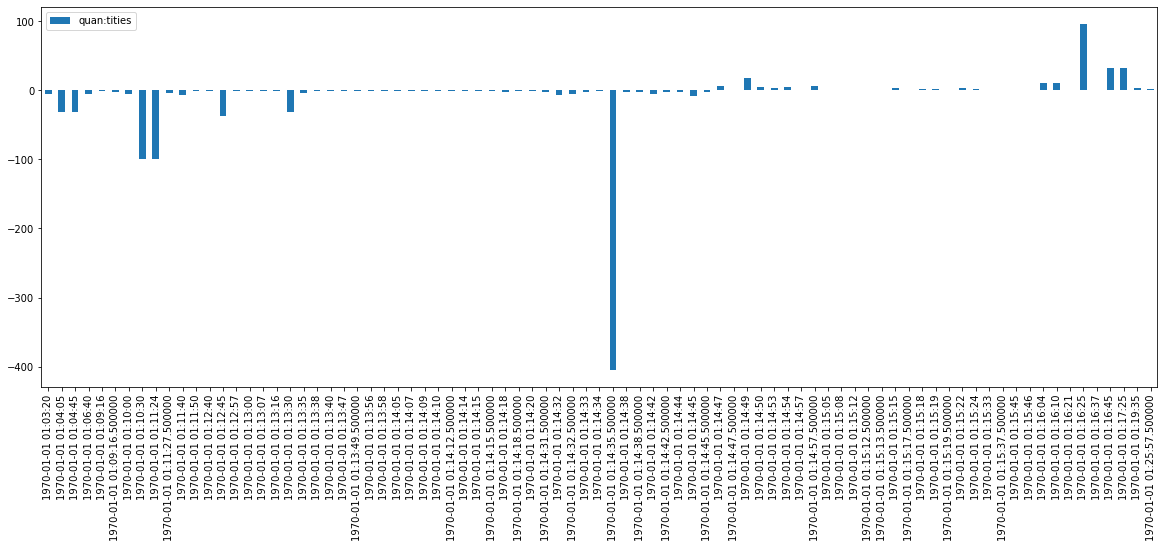

In [20]:
response = requests.get(f"{server}/getLOBstate")
tickSize =  requests.get(f"{server}/getticksize").json()['ticksize']
tickSize = 0.5
try:
    LOBstate = pd.read_json(response.json()['LOBstate'])
    print(LOBstate)
    LOBstate.sort_index(inplace=True)
    minPrice = LOBstate.index[0]
    maxPrice = LOBstate.index[-1]
#     print(LOBstate)
#     LOBstate = LOBstate.reindex(range(minPrice, maxPrice, tickSize))
    LOBstate.columns = ['quan:tities']

    LOBstate.plot.bar(figsize=(20, 7))
except:
    print('LOB is empty')

In [23]:
LOBstate.abs().sum()

quan:tities    1097
dtype: int64

## Simulation configuration

In [3]:
config =   {'agents'      : {'agent1' : {'type'         : 'randomAgent',
                                        'subtype'       : 'randomLimitBuyer',
                                        'server'        : server,
                                        'intensity'     : 0.4,
                                        'quantityRange' : [50, 200, 10]},
                            'agent2' : {'type'          : 'randomAgent',
                                        'subtype'       : 'randomMarketBuyer',
                                        'server'        : server,
                                        'intensity'     : 0.4,
                                        'quantityRange' : [50, 200, 10]},
                            'agent3' : {'type'          : 'randomAgent',
                                        'subtype'       : 'randomLimitSeller',
                                        'server'        : server,
                                        'intensity'     : 0.4,
                                        'quantityRange' : [50, 200, 10]},
                            'agent4' : {'type'          : 'randomAgent',
                                        'subtype'       : 'randomMarketSeller',
                                        'server'        : server,
                                        'intensity'     : 0.4,
                                        'quantityRange' : [50, 200, 10]},
                            'MM'     : {'type'          : 'basicMM',
                                        'server'        : server,
                                        'refQuantity'   : 100,
                                        'refPrice'      : 100}}}

## Create the agents

In [4]:
agentFactory = {} # keeps references on agents
config_agents = config['agents']

def getInstance(module, defObject, **kwargs):
    typ = defObject['type']
    exec(f'global myModule; from {module} import {typ} as myModule')
    class_ = getattr(myModule, typ)
    return class_(**defObject)

for agent in config_agents:
    agentFactory[agent] = getInstance('mimicLOB.agent', config_agents[agent])        

## Launch News

In [5]:
# start news
response = requests.get(f"{server}/launchNews").json()
response['status']

'DONE'

## Launch Trading

In [7]:
sched = BackgroundScheduler()
sched.start()

def startSimulation():
    for agent in agentFactory:
        agentFactory[agent].jobSO = sched.add_job(agentFactory[agent].sendOrders, 'interval', seconds=0.1, jitter=0.1)
        agentFactory[agent].JobCO = sched.add_job(agentFactory[agent].cancelFarAwayOrders, 'interval', seconds=1, jitter=0.5) 

def stopSimulation():
    for agent in agentFactory:
        if agentFactory[agent].JobSO is not None:  agentFactory[agent].JobSO.remove()       
        if agentFactory[agent].JobCO is not None:  agentFactory[agent].JobCO.remove()    
        agentFactory[agent].JobSO = None
        agentFactory[agent].JobCO = None

In [8]:
startSimulation()

Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:53:34 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:53:36 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:53:37 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:53:38 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:53:42 CEST)" skipped: maximum number of running instances reached (1)
Job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:53:42 CEST)" raised an exception
Traceback (most recent call last):
  File "C:\Users\fayca\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "C:\Users\fayca\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 384, in _make_request
    six.raise_from(e, None)
  File "<string>", line 2, in raise_from
  File "C:\Users\fayca\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 380, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Users\fayca\Anaconda3\lib\http\client.py", line 1336, in getresponse
    response.begin()
  File "C:\Users\fayca\Anaconda3\lib\http\client.py", line 306, in begin
    version, status, reason = self._read_status()
  File 

ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:53:43 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:53:43 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:53:44 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:53:46 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:53:48 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:53:49 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:53:50 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:53:51 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:53:51 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'


Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:53:51 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:53:52 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:53:52 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'


Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:53:53 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:53:53 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:53:54 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'


Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:53:57 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:53:58 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:53:58 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:53:58 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'


Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:53:59 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'


Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:00 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:00 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:01 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:01 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:02 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:05 CEST)" skipped: maximum number o

ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'


Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:18 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:18 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:19 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:19 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:19 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:19 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:21 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'
ERROR canceling far away orders float() argument must be a string or a number, not '

Job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:31 CEST)" raised an exception
Traceback (most recent call last):
  File "C:\Users\fayca\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "C:\Users\fayca\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 384, in _make_request
    six.raise_from(e, None)
  File "<string>", line 2, in raise_from
  File "C:\Users\fayca\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 380, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Users\fayca\Anaconda3\lib\http\client.py", line 1336, in getresponse
    response.begin()
  File "C:\Users\fayca\Anaconda3\lib\http\client.py", line 306, in begin
    version, status, reason = self._read_status()
  File "C:\Users\fayca\Anaconda3\lib\http\client.py", line 275, in _read_status
    raise RemoteDisconnected("Remote end closed connection without"
http.client.RemoteDisconn

Job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:31 CEST)" raised an exception
Traceback (most recent call last):
  File "C:\Users\fayca\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "C:\Users\fayca\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 384, in _make_request
    six.raise_from(e, None)
  File "<string>", line 2, in raise_from
  File "C:\Users\fayca\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 380, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Users\fayca\Anaconda3\lib\http\client.py", line 1336, in getresponse
    response.begin()
  File "C:\Users\fayca\Anaconda3\lib\http\client.py", line 306, in begin
    version, status, reason = self._read_status()
  File "C:\Users\fayca\Anaconda3\lib\http\client.py", line 275, in _read_status
    raise RemoteDisconnected("Remote end closed connection without"
http.client.RemoteDisconn

Job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:31 CEST)" raised an exception
Traceback (most recent call last):
  File "C:\Users\fayca\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "C:\Users\fayca\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 384, in _make_request
    six.raise_from(e, None)
  File "<string>", line 2, in raise_from
  File "C:\Users\fayca\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 380, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Users\fayca\Anaconda3\lib\http\client.py", line 1336, in getresponse
    response.begin()
  File "C:\Users\fayca\Anaconda3\lib\http\client.py", line 306, in begin
    version, status, reason = self._read_status()
  File "C:\Users\fayca\Anaconda3\lib\http\client.py", line 275, in _read_status
    raise RemoteDisconnected("Remote end closed connection without"
http.client.RemoteDisconn

Job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:31 CEST)" raised an exception
Traceback (most recent call last):
  File "C:\Users\fayca\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "C:\Users\fayca\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 384, in _make_request
    six.raise_from(e, None)
  File "<string>", line 2, in raise_from
  File "C:\Users\fayca\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 380, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Users\fayca\Anaconda3\lib\http\client.py", line 1336, in getresponse
    response.begin()
  File "C:\Users\fayca\Anaconda3\lib\http\client.py", line 306, in begin
    version, status, reason = self._read_status()
  File "C:\Users\fayca\Anaconda3\lib\http\client.py", line 275, in _read_status
    raise RemoteDisconnected("Remote end closed connection without"
http.client.RemoteDisconn

Job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:31 CEST)" raised an exception
Traceback (most recent call last):
  File "C:\Users\fayca\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "C:\Users\fayca\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 384, in _make_request
    six.raise_from(e, None)
  File "<string>", line 2, in raise_from
  File "C:\Users\fayca\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 380, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Users\fayca\Anaconda3\lib\http\client.py", line 1336, in getresponse
    response.begin()
  File "C:\Users\fayca\Anaconda3\lib\http\client.py", line 306, in begin
    version, status, reason = self._read_status()
  File "C:\Users\fayca\Anaconda3\lib\http\client.py", line 275, in _read_status
    raise RemoteDisconnected("Remote end closed connection without"
http.client.RemoteDisconn

Job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:32 CEST)" raised an exception
Traceback (most recent call last):
  File "C:\Users\fayca\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "C:\Users\fayca\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 384, in _make_request
    six.raise_from(e, None)
  File "<string>", line 2, in raise_from
  File "C:\Users\fayca\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 380, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Users\fayca\Anaconda3\lib\http\client.py", line 1336, in getresponse
    response.begin()
  File "C:\Users\fayca\Anaconda3\lib\http\client.py", line 306, in begin
    version, status, reason = self._read_status()
  File "C:\Users\fayca\Anaconda3\lib\http\client.py", line 275, in _read_status
    raise RemoteDisconnected("Remote end closed connection without"
http.client.RemoteDisconn

ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'


Job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:32 CEST)" raised an exception
Traceback (most recent call last):
  File "C:\Users\fayca\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "C:\Users\fayca\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 384, in _make_request
    six.raise_from(e, None)
  File "<string>", line 2, in raise_from
  File "C:\Users\fayca\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 380, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Users\fayca\Anaconda3\lib\http\client.py", line 1336, in getresponse
    response.begin()
  File "C:\Users\fayca\Anaconda3\lib\http\client.py", line 306, in begin
    version, status, reason = self._read_status()
  File "C:\Users\fayca\Anaconda3\lib\http\client.py", line 275, in _read_status
    raise RemoteDisconnected("Remote end closed connection without"
http.client.RemoteDisconn

Job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:32 CEST)" raised an exception
Traceback (most recent call last):
  File "C:\Users\fayca\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "C:\Users\fayca\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 384, in _make_request
    six.raise_from(e, None)
  File "<string>", line 2, in raise_from
  File "C:\Users\fayca\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 380, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Users\fayca\Anaconda3\lib\http\client.py", line 1336, in getresponse
    response.begin()
  File "C:\Users\fayca\Anaconda3\lib\http\client.py", line 306, in begin
    version, status, reason = self._read_status()
  File "C:\Users\fayca\Anaconda3\lib\http\client.py", line 275, in _read_status
    raise RemoteDisconnected("Remote end closed connection without"
http.client.RemoteDisconn

Job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:32 CEST)" raised an exception
Traceback (most recent call last):
  File "C:\Users\fayca\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "C:\Users\fayca\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 384, in _make_request
    six.raise_from(e, None)
  File "<string>", line 2, in raise_from
  File "C:\Users\fayca\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 380, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Users\fayca\Anaconda3\lib\http\client.py", line 1336, in getresponse
    response.begin()
  File "C:\Users\fayca\Anaconda3\lib\http\client.py", line 306, in begin
    version, status, reason = self._read_status()
  File "C:\Users\fayca\Anaconda3\lib\http\client.py", line 275, in _read_status
    raise RemoteDisconnected("Remote end closed connection without"
http.client.RemoteDisconn

Job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:32 CEST)" raised an exception
Traceback (most recent call last):
  File "C:\Users\fayca\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "C:\Users\fayca\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 384, in _make_request
    six.raise_from(e, None)
  File "<string>", line 2, in raise_from
  File "C:\Users\fayca\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 380, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Users\fayca\Anaconda3\lib\http\client.py", line 1336, in getresponse
    response.begin()
  File "C:\Users\fayca\Anaconda3\lib\http\client.py", line 306, in begin
    version, status, reason = self._read_status()
  File "C:\Users\fayca\Anaconda3\lib\http\client.py", line 275, in _read_status
    raise RemoteDisconnected("Remote end closed connection without"
http.client.RemoteDisconn

Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:32 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:35 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:35 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:37 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:37 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:37 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:38 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:39 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:40 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:41 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:42 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'


Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:43 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:43 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'


Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:44 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:45 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:45 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:46 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:48 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.cancelFarAwayOrders (trigger: interval[0:00:01], next run at: 2020-04-04 20:54:48 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:49 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:50 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:54:50 CEST)" skipped: maximum number

Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:55:17 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:55:17 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:55:17 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.cancelFarAwayOrders (trigger: interval[0:00:01], next run at: 2020-04-04 20:55:19 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:55:19 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:55:21 CEST)" skipped: maximum number of 

ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:55:24 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.cancelFarAwayOrders (trigger: interval[0:00:01], next run at: 2020-04-04 20:55:24 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:55:24 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:55:25 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:55:25 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:55:27 CEST)" skipped: maximum number

ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:55:30 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:55:30 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.cancelFarAwayOrders (trigger: interval[0:00:01], next run at: 2020-04-04 20:55:30 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:55:30 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:55:31 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:55:31 CEST)" skipped: maximum nu

ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:55:41 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:55:42 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'


Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:55:43 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:55:44 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:55:44 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:55:45 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:55:45 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:55:45 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.cancelFarAwayOrders (trigger: interval[0:00:01], next run at: 2020-04-04 20:55:45 CEST)" skipped: maximum number

ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'


Execution of job "randomAgent.cancelFarAwayOrders (trigger: interval[0:00:01], next run at: 2020-04-04 20:55:49 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.cancelFarAwayOrders (trigger: interval[0:00:01], next run at: 2020-04-04 20:55:50 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:55:50 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "randomAgent.cancelFarAwayOrders (trigger: interval[0:00:01], next run at: 2020-04-04 20:55:51 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:55:52 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:55:52 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.cancelFarAwayOrders (trigger: interval[0:00:01], next run at: 2020-04-04 20:55:52 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:55:54 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:55:54 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:55:57 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:55:57 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:55:57 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:55:57 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.cancelFarAwayOrders (trigger: interval[0:00:01], next run at: 2020-04-04 20:55:58 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.cancelFarAwayOrders (trigger: interval[0:00:01], next run at: 2020-04-04 20:55:58 CEST)" skipped: maximum 

ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "randomAgent.cancelFarAwayOrders (trigger: interval[0:00:01], next run at: 2020-04-04 20:56:04 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'


Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:56:06 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.cancelFarAwayOrders (trigger: interval[0:00:01], next run at: 2020-04-04 20:56:06 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:56:07 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.cancelFarAwayOrders (trigger: interval[0:00:01], next run at: 2020-04-04 20:56:07 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:56:08 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:56:08 CEST)" skipped: maximum 

ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'


Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:56:11 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.cancelFarAwayOrders (trigger: interval[0:00:01], next run at: 2020-04-04 20:56:11 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:56:11 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:56:11 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:56:11 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.cancelFarAwayOrders (trigger: interval[0:00:01], next run at: 2020-04-04 20:56:11 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:56:13 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "randomAgent.cancelFarAwayOrders (trigger: interval[0:00:01], next run at: 2020-04-04 20:56:13 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.cancelFarAwayOrders (trigger: interval[0:00:01], next run at: 2020-04-04 20:56:14 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:56:14 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "randomAgent.cancelFarAwayOrders (trigger: interval[0:00:01], next run at: 2020-04-04 20:56:15 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:56:16 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:56:17 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "randomAgent.cancelFarAwayOrders (trigger: interval[0:00:01], next run at: 2020-04-04 20:56:17 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:56:17 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.cancelFarAwayOrders (trigger: interval[0:00:01], next run at: 2020-04-04 20:56:18 CEST)" skipped: maximum number of running instances reached (1)
Job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:56:18 CEST)" raised an exception
Traceback (most recent call last):
  File "C:\Users\fayca\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "C:\Users\fayca\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 384, in _make_request
    six.raise_from(e, None)
  File "<string>", line 2, in raise_from
  File "C:\Users\fayca\Anaconda

ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'



Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:56:19 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:56:19 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:56:19 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.cancelFarAwayOrders (trigger: interval[0:00:01], next run at: 2020-04-04 20:56:19 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.cancelFarAwayOrders (trigger: interval[0:00:01], next run at: 2020-04-04 20:56:20 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.cancelFarAwayOrders (trigger: interval[0:00:01], next run at: 2020-04-04 20:56:21 CEST)" skipped: ma

ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'

ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'


Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:56:37 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:56:37 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:56:37 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:56:38 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:56:39 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.cancelFarAwayOrders (trigger: interval[0:00:01], next run at: 2020-04-04 20:56:39 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'


Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:56:40 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:56:40 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:56:42 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:56:42 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:56:42 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'

ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "randomAgent.cancelFarAwayOrders (trigger: interval[0:00:01], next run at: 2020-04-04 20:56:42 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'


Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:56:44 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:56:45 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:56:46 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:56:46 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.cancelFarAwayOrders (trigger: interval[0:00:01], next run at: 2020-04-04 20:56:46 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.cancelFarAwayOrders (trigger: interval[0:00:01], next run at: 2020-04-04 20:56:46 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:56:47 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.cancelFarAwayOrders (trigger: interval[0:00:01], next run at: 2020-04-04 20:56:48 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:56:48 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:56:49 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'


Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:56:50 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:56:50 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.cancelFarAwayOrders (trigger: interval[0:00:01], next run at: 2020-04-04 20:56:51 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.cancelFarAwayOrders (trigger: interval[0:00:01], next run at: 2020-04-04 20:56:51 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.cancelFarAwayOrders (trigger: interval[0:00:01], next run at: 2020-04-04 20:56:51 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:56:51 CEST)" skipped: maximu

ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'

ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "randomAgent.cancelFarAwayOrders (trigger: interval[0:00:01], next run at: 2020-04-04 20:57:03 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:57:04 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'


Execution of job "randomAgent.cancelFarAwayOrders (trigger: interval[0:00:01], next run at: 2020-04-04 20:57:05 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:57:05 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.cancelFarAwayOrders (trigger: interval[0:00:01], next run at: 2020-04-04 20:57:05 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.cancelFarAwayOrders (trigger: interval[0:00:01], next run at: 2020-04-04 20:57:06 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:57:06 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:57:06 CEST)" skipped: maximu

Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:57:19 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:57:19 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.cancelFarAwayOrders (trigger: interval[0:00:01], next run at: 2020-04-04 20:57:20 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:57:20 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:57:20 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:57:20 CEST)" skipped: maximum number

ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "randomAgent.cancelFarAwayOrders (trigger: interval[0:00:01], next run at: 2020-04-04 20:57:23 CEST)" skipped: maximum number of running instances reached (1)
Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:57:23 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'


Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:57:24 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'


Execution of job "basicMM.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:57:27 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'



Execution of job "randomAgent.cancelFarAwayOrders (trigger: interval[0:00:01], next run at: 2020-04-04 20:57:28 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'
ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'


Execution of job "randomAgent.cancelFarAwayOrders (trigger: interval[0:00:01], next run at: 2020-04-04 20:57:29 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'


Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:57:29 CEST)" skipped: maximum number of running instances reached (1)


ERROR canceling far away orders float() argument must be a string or a number, not 'NoneType'
ERROR canceling far away orders unsupported operand type(s) for -: 'NoneType' and 'int'


## Pause Trading

In [23]:
try:
    sched.pause()
except Exception as e:
    print(e)
response = requests.get(f"{server}/resetLOB").json()
response['status']

Scheduler is not running


'DONE'

## Resume Trading

In [22]:
try:
    sched.resume()
except Exception as e:
    print(e)

Scheduler is not running


## Stop Trading & reset LOB

In [10]:
try:
    sched.shutdown()
except Exception as e:
    print(e)


Execution of job "randomAgent.sendOrders (trigger: interval[0:00:00.100000], next run at: 2020-04-04 20:59:32 CEST)" skipped: maximum number of running instances reached (1)


# Send orders

#### limit sell order @101

In [53]:
limitsellorder =  {'type'      : 'limit', 
                   'side'      : 'ask', 
                   'quantity'  : 100,
                   'price'     : 11,
                   'trader_id'  : 0}

response = requests.get(f"{server}/sendOrder", 
                        json=limitsellorder).json()

trades        = response['trades']
pendingOrders = response['pendingOrders']

if pendingOrders is not None:
    pendingtrades[pendingOrders['order_id']] = pendingOrders
if trades is not None:
    for trade in trades:
        executedtrades[trade['party2'][0]] = trade  

response['status']

'SENT'

#### limit sell order @102

In [62]:
limitsellorder =  {'type'      : 'limit', 
                   'side'      : 'ask', 
                   'quantity'  : 40,
                   'price'     : 102,
                   'trader_id'  : 1}

response = requests.get(f"{server}/sendOrder", 
                        json=limitsellorder).json()
trades        = response['trades']
pendingOrders = response['pendingOrders']

if pendingOrders is not None:
    pendingtrades[pendingOrders['order_id']] = pendingOrders
if trades is not None:
    for trade in trades:
        executedtrades[trade['party2'][0]] = trade  
        
response['status']

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

#### limit buy orders @100 & 99 & 94

In [65]:
limitbuyorders =  [{'type'      : 'limit', 
                    'side'      : 'bid', 
                    'quantity'  : 50,
                    'price'     : 100,
                    'trader_id'  : 2},
                   {'type'      : 'limit', 
                    'side'      : 'bid', 
                    'quantity'  : 50,
                    'price'     : 99,
                    'trader_id'  : 3},
                   {'type'      : 'limit', 
                    'side'      : 'bid', 
                    'quantity'  : 50,
                    'price'     : 94,
                    'trader_id'  : 4}]
for order_ in limitbuyorders:
    response = requests.get(f"{server}/sendOrder", 
                            json=order_).json()
    trades        = response['trades']
    pendingOrders = response['pendingOrders']
    if pendingOrders is not None:
        pendingtrades[pendingOrders['order_id']] = pendingOrders
    if trades is not None:
        for trade in trades:
            executedtrades[trade['party2'][0]] = trade  
    display(response['status'])

'SENT'

'SENT'

'SENT'

In [66]:
# This one will be executed, and some orders will remain in the book
Marketablelimitbuyorder =  {'type'     : 'limit', 
                           'side'      : 'bid', 
                           'quantity'  : 150,
                           'price'     : 101,
                           'trader_id'  : 521}

response      = requests.get(f"{server}/sendOrder", 
                        json=Marketablelimitbuyorder).json()
trades        = response['trades']
pendingOrders = response['pendingOrders']
if pendingOrders is not None:
    pendingtrades[pendingOrders['order_id']] = pendingOrders
if trades is not None:
    for trade in trades:
        executedtrades[trade['party2'][0]] = trade       
response['status']

'SENT'

In [67]:
# This one will be executed, and some orders will remain in the book
Marketablelimitsellorder =  {'type'     : 'limit', 
                           'side'      : 'ask', 
                           'quantity'  : 100,
                           'price'     : 101,
                           'trader_id'  : 522}

response      = requests.get(f"{server}/sendOrder", 
                        json=Marketablelimitsellorder).json()
trades        = response['trades']
pendingOrders = response['pendingOrders']
if pendingOrders is not None:
    pendingtrades[pendingOrders['order_id']] = pendingOrders
if trades is not None:
    for trade in trades:
        executedtrades[trade['party2'][0]] = trade     
response['status']   

'SENT'

In [68]:
pprint(executedtrades)

{521: {'party1': [0, 'ask', 1, None],
       'party2': [521, 'bid', None, None],
       'price': 101,
       'quantity': 100,
       'time': 6,
       'timestamp': 6},
 522: {'party1': [521, 'bid', 6, None],
       'party2': [522, 'ask', None, None],
       'price': 101,
       'quantity': 50,
       'time': 7,
       'timestamp': 7}}


In [74]:
pprint(pendingtrades)

{1: {'order_id': 1,
     'price': 101,
     'quantity': 100,
     'side': 'ask',
     'timestamp': 1,
     'trader_id': 0,
     'type': 'limit'},
 2: {'order_id': 2,
     'price': 102,
     'quantity': 40,
     'side': 'ask',
     'timestamp': 2,
     'trader_id': 1,
     'type': 'limit'},
 3: {'order_id': 3,
     'price': 100,
     'quantity': 50,
     'side': 'bid',
     'timestamp': 3,
     'trader_id': 2,
     'type': 'limit'},
 4: {'order_id': 4,
     'price': 99,
     'quantity': 50,
     'side': 'bid',
     'timestamp': 4,
     'trader_id': 3,
     'type': 'limit'},
 6: {'order_id': 6,
     'price': 101,
     'quantity': 50,
     'side': 'bid',
     'timestamp': 6,
     'trader_id': 521,
     'type': 'limit'},
 7: {'order_id': 7,
     'price': 101,
     'quantity': 50,
     'side': 'ask',
     'timestamp': 7,
     'trader_id': 522,
     'type': 'limit'}}


 # Cancel orders if they are too far away

In [73]:
# tick size
tickSize = requests.get(f"{server}/getticksize").json()['ticksize']
keys_ = pendingtrades.keys()
for key_ in keys_:
    order = pendingtrades[key_]
    
    # if they are executed    
    #if they too far away
    side = order['side']
    price = order['price']
    
    # best price at side
    if side == 'bid':
        bestPrice = requests.get(f"{server}/getbestbid").json()['bestbid']
    else:
        bestPrice = requests.get(f"{server}/getbestask").json()['bestask']
    
    # if best price < 3 * tickSize, cancel
    if (((side=='bid') & (price < bestPrice - 3*tickSize)) | ((side=='ask') & (price > bestPrice + 3*tickSize))):
            print('CANCELING : ')
            pprint(order)
            params = {'side':side, 'id':key_}
            response = requests.get(f"{server}/cancelOrder",
                                    json=params).json()
            display(response['status'])
            del pendingtrades[key_]

CANCELING : 
{'order_id': 5,
 'price': 94,
 'quantity': 50,
 'side': 'bid',
 'timestamp': 5,
 'trader_id': 4,
 'type': 'limit'}


'CANCELED'

In [ ]:
list(pendingtrades.keys())

# get your current book value

In [ ]:
executedtrades

In [ ]:
# Cancel order because it is too far from the best bid
# and remove it from pending orders


# Send orders according to a poisson process

In [2]:
import numpy as np
s = np.random.poisson(0.01, 10000)

In [5]:
plt.plot(np.cumsum(s))

92

# Create an agent and add them to the LOB simulator

# Send Orders during simulation

In [78]:
limitsellorder =  {'type'      : 'limit', 
                   'side'      : 'ask', 
                   'quantity'  : 100,
                   'price'     : 151,
                   'trader_id'  : 0}

response = requests.get(f"{server}/sendOrder", 
                        json=limitsellorder).json()

trades        = response['trades']
pendingOrders = response['pendingOrders']

if pendingOrders is not None:
    pendingtrades[pendingOrders['order_id']] = pendingOrders
if trades is not None:
    for trade in trades:
        executedtrades[trade['party2'][0]] = trade  

response['status']

ConnectionError: HTTPConnectionPool(host='127.0.0.1', port=5000): Max retries exceeded with url: /sendOrder (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x00000209CEEA9E48>: Failed to establish a new connection: [WinError 10061] Aucune connexion n’a pu être établie car l’ordinateur cible l’a expressément refusée'))

In [77]:
executedtrades

SortedDict({521: {'party1': [0, 'ask', 1, None], 'party2': [521, 'bid', None, None], 'price': 101, 'quantity': 100, 'time': 6, 'timestamp': 6}, 522: {'party1': [521, 'bid', 6, None], 'party2': [522, 'ask', None, None], 'price': 101, 'quantity': 50, 'time': 7, 'timestamp': 7}})

## Get Price Tape

'open : 100'

'high : 105'

'open : 97'

'close : 100'

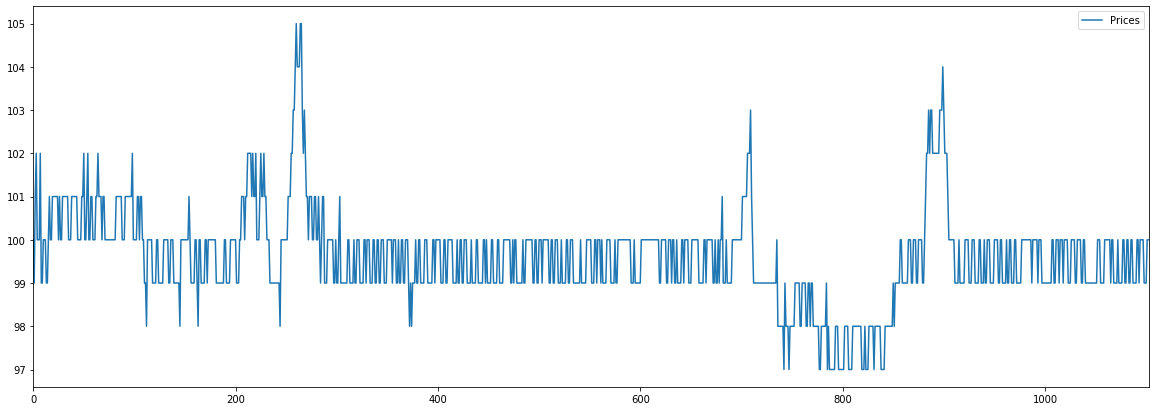

In [21]:
histoPrices = requests.get(f"{server}/getPriceTape",).json()['PriceTape']
histoPrices = pd.DataFrame([histoPrices]).T; histoPrices.columns = ['Prices']
histoPrices.plot(figsize=(20,7))
# display(histoPrices.describe())
display(f'open : {histoPrices.iloc[0,0]}')
display(f'high : {histoPrices.max()[0]}')
display(f'open : {histoPrices.min()[0]}')
display(f'close : {histoPrices.iloc[-1, 0]}')
plt.show()

## Get transaction Tape

In [22]:
TransactionTape = requests.get(f"{server}/getTransactionTape").json()['TransactionTape']
pd.read_json(TransactionTape)

,trader_id1,side1,trader_id2,side2,price,quantity
9,marketMaker,bid,0,ask,99,30
12,marketMaker,ask,0,bid,102,40
32,0,ask,0,bid,100,50
47,marketMaker,ask,0,bid,102,10
69,0,bid,0,ask,99,90
...,...,...,...,...,...,...
1667,0,ask,0,bid,98,90
1669,0,ask,0,bid,98,90
1671,0,bid,0,ask,97,20
1672,0,ask,0,bid,98,10
